#Generative Adversarial Network (GAN)

Código base:
https://github.com/eriklindernoren/Keras-GAN



In [1]:
#Carregar bibliotecas
%tensorflow_version 1.x
from __future__ import print_function, division
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np
import random

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
input_shape = (500,)
latent_dim = 100
optimizer = Adam(0.0002, 0.5)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
#gerar dados de entrada com distribuição uniforme
import pandas as pd
X = pd.DataFrame(np.random.uniform(0,1,size=(10000, latent_dim)))
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.160343,0.509962,0.806504,0.686862,0.748879,0.634685,0.383458,0.220570,0.198362,0.796757,0.380044,0.537361,0.380687,0.476050,0.016688,0.729499,0.702138,0.247516,0.925245,0.564354,0.498261,0.209424,0.947651,0.492031,0.306226,0.713324,0.855690,0.594361,0.312884,0.078757,0.166644,0.956119,0.922743,0.462565,0.820753,0.465932,0.660328,0.104626,0.453106,0.815297,...,0.994921,0.927210,0.204442,0.679061,0.513138,0.802010,0.489051,0.784672,0.945544,0.581142,0.815110,0.815810,0.126179,0.681293,0.474383,0.090985,0.084645,0.117103,0.021930,0.124443,0.402436,0.146013,0.066144,0.628994,0.462100,0.354748,0.703393,0.066328,0.813692,0.868701,0.304586,0.927569,0.827385,0.883209,0.152624,0.010730,0.313089,0.425712,0.970157,0.083200
1,0.510868,0.524741,0.307717,0.366131,0.216413,0.624652,0.504782,0.529180,0.619874,0.475773,0.524532,0.396412,0.998114,0.889751,0.383601,0.877780,0.815211,0.650942,0.604481,0.346484,0.698220,0.924582,0.051564,0.970881,0.065224,0.204282,0.104950,0.761807,0.202988,0.189389,0.232035,0.700348,0.811902,0.302592,0.466064,0.952488,0.270360,0.310773,0.868172,0.637385,...,0.939380,0.355990,0.460890,0.080781,0.861893,0.829693,0.455761,0.882917,0.943612,0.854687,0.317108,0.183583,0.741891,0.414022,0.682200,0.390285,0.825880,0.683064,0.882908,0.924958,0.812720,0.282469,0.287012,0.201766,0.421350,0.537033,0.218913,0.412336,0.125242,0.839841,0.641791,0.491899,0.173396,0.475642,0.702634,0.869018,0.826215,0.832771,0.683387,0.145022
2,0.811730,0.016631,0.244378,0.664412,0.135194,0.123285,0.380625,0.938014,0.489456,0.288613,0.741111,0.300143,0.352769,0.909970,0.237942,0.340045,0.698739,0.433370,0.795163,0.154817,0.387771,0.394501,0.385762,0.724103,0.544305,0.144208,0.349900,0.655792,0.652594,0.657724,0.546650,0.441722,0.784754,0.972655,0.545896,0.023850,0.122427,0.848623,0.070465,0.152192,...,0.090436,0.293064,0.898491,0.978389,0.291021,0.807798,0.964989,0.062188,0.155564,0.180327,0.054505,0.309308,0.518922,0.639995,0.234219,0.280399,0.943179,0.453220,0.498564,0.803956,0.382153,0.758260,0.098363,0.749652,0.100145,0.593869,0.327410,0.061885,0.428529,0.424560,0.664450,0.969787,0.562061,0.736840,0.138492,0.799718,0.442562,0.029477,0.553425,0.390609
3,0.086887,0.814480,0.282420,0.174170,0.629009,0.439404,0.387728,0.857408,0.083348,0.548280,0.290558,0.356428,0.263176,0.714119,0.993661,0.015874,0.803311,0.377587,0.875252,0.335683,0.946294,0.898554,0.847263,0.681236,0.134843,0.292977,0.397709,0.292302,0.577385,0.788341,0.527311,0.662642,0.976808,0.956491,0.740798,0.509047,0.420671,0.816744,0.338318,0.299872,...,0.990444,0.913466,0.597345,0.361834,0.840023,0.410143,0.787966,0.435560,0.172788,0.529194,0.693671,0.746692,0.608075,0.252344,0.535158,0.543789,0.512687,0.007510,0.949276,0.307637,0.443033,0.474408,0.345844,0.538776,0.936127,0.421708,0.408837,0.065723,0.931089,0.324617,0.283425,0.689374,0.774243,0.336262,0.176513,0.488060,0.875045,0.088167,0.449181,0.733853
4,0.459209,0.469558,0.883525,0.485687,0.103766,0.314145,0.729646,0.048924,0.031381,0.918435,0.890344,0.602196,0.805704,0.585051,0.190137,0.756743,0.582530,0.049145,0.542839,0.189908,0.869928,0.045493,0.704122,0.127457,0.178037,0.575410,0.170861,0.170882,0.689254,0.213677,0.792398,0.670527,0.508841,0.012036,0.299667,0.398801,0.749592,0.324998,0.475478,0.260158,...,0.689714,0.014352,0.782516,0.945629,0.935028,0.564474,0.475771,0.853130,0.295317,0.504918,0.779500,0.553961,0.059667,0.980900,0.219853,0.117366,0.646991,0.719602,0.130332,0.807931,0.596560,0.935747,0.480088,0.718294,0.391661,0.170145,0.539148,0.957808,0.279329,0.001747,0.704631,0.145805,0.699587,0.807975,0.122079,0.811213,0.280763,0.127867,0.729372,0.018951


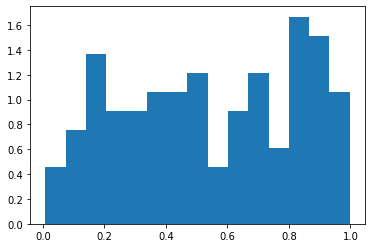

In [ ]:
#distribuicao para amostra
histogram_i = plt.hist(X.iloc[1,:], 15, density=True)

###Exercício 1: Gerar dados com distbuição normal. Salvar em uma variável chamada 'y'. Plotar o histograma. Imprimir a média e o desvio de uma amostra qualquer.

-0.0023379611727024213
1.00039535471467


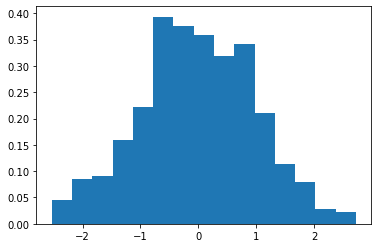

In [ ]:
#gerar dados target de saída com distriuição normal
y = pd.DataFrame(np.random.normal(0,1,size=(10000, input_shape[0])))
hist = plt.hist(y.iloc[0,:], 15, density=True)

print(y[0].mean()) #média
print(y[0].std())  #des

In [ ]:
# Criar o Gerador
generator = Sequential()

generator.add(Dense(256, input_dim=latent_dim))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(1024))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(np.prod(input_shape), activation='linear'))
generator.add(Reshape(input_shape))
generator.summary()

noise = Input(shape=(latent_dim,))
distribution = generator(noise)
generator = Model(noise, distribution)

# Compilar o gerador
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)             

In [ ]:
# Criar o Discriminador
discriminator = Sequential()

discriminator.add(Dense(512, input_shape=input_shape))
discriminator.add(LeakyReLU(alpha=0.2))

discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))

discriminator.add(Dense(1, activation='sigmoid'))
discriminator.summary()

distribution = Input(shape=input_shape)
validity = discriminator(distribution)
discriminator = Model(distribution, validity)

# Compilar o discriminador
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               256512    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 388,097
Trainable params: 388,097
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# O gerador recebe um ruído como entrada e gera a amostra com a distribuição aprendida
input = Input(shape=(latent_dim,))
gen_data = generator(input)
validity = discriminator(gen_data)

# Para o modelo combinado, somente treinaremos o gerador
discriminator.trainable = False


# Modelo combinado: stacked generator and discriminator
# Treina o gerador para enganar o discriminador
combined = Model(input, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

# Mostrar a estrutura do modelo criado
config = combined.get_config()
model = Model.from_config(config)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 500)               1202420   
_________________________________________________________________
model_2 (Model)              (None, 1)                 388097    
Total params: 1,590,517
Trainable params: 1,586,933
Non-trainable params: 3,584
_________________________________________________________________


In [ ]:
batch_size=32
epochs=10000

# Vetores com 0s e 1s indicando, respectivamente, amostras fakes e reais
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):

# ---------------------
#  Treina o Discriminador
# ---------------------
# Seleciona um batch aleatório de dados
  idx = np.random.randint(0, len(X[1]), batch_size)
  imgs = y.iloc[idx,:]
  noise = X.iloc[idx,:]

  # Gera um batch de novos dados
  gen_imgs = generator.predict(noise)

  # Treina o discriminador
  d_loss_real = discriminator.train_on_batch(imgs, valid)
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  # ---------------------
  #  Treina o Gerador
  # ---------------------

  # Treina o gerador para que faça o discriminador classificar os dados criados como reais
  g_loss = combined.train_on_batch(noise, valid)

  # Progresso
  print ("%d [D loss: %f, accD.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))


/tensorflow-1.15.2/python3.6/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.764953, accD.: 26.56%] [G loss: 0.630360]
1 [D loss: 0.647950, accD.: 39.06%] [G loss: 0.367157]
2 [D loss: 0.568484, accD.: 46.88%] [G loss: 0.213870]
3 [D loss: 0.511546, accD.: 65.62%] [G loss: 0.141958]


/tensorflow-1.15.2/python3.6/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


A saída de streaming foi truncada nas últimas 5000 linhas.
5001 [D loss: 0.703313, accD.: 39.06%] [G loss: 0.724206]
5002 [D loss: 0.696193, accD.: 46.88%] [G loss: 0.735988]
5003 [D loss: 0.705294, accD.: 40.62%] [G loss: 0.726433]
5004 [D loss: 0.704070, accD.: 35.94%] [G loss: 0.724811]
5005 [D loss: 0.708215, accD.: 42.19%] [G loss: 0.724189]
5006 [D loss: 0.708789, accD.: 40.62%] [G loss: 0.724232]
5007 [D loss: 0.696604, accD.: 39.06%] [G loss: 0.735959]
5008 [D loss: 0.708110, accD.: 45.31%] [G loss: 0.734873]
5009 [D loss: 0.697896, accD.: 50.00%] [G loss: 0.741982]
5010 [D loss: 0.697602, accD.: 43.75%] [G loss: 0.729523]
5011 [D loss: 0.720133, accD.: 31.25%] [G loss: 0.721661]
5012 [D loss: 0.695256, accD.: 51.56%] [G loss: 0.737688]
5013 [D loss: 0.708131, accD.: 40.62%] [G loss: 0.734981]
5014 [D loss: 0.705373, accD.: 40.62%] [G loss: 0.730920]
5015 [D loss: 0.707542, accD.: 42.19%] [G loss: 0.728005]
5016 [D loss: 0.709855, accD.: 39.06%] [G loss: 0.721781]
5017 [D loss:

###Exercício 2: Criar uma amostra para teste. Visualizar a base (função head())

In [ ]:
teste = pd.DataFrame(np.random.uniform(0,1,size=(1000, latent_dim)))
teste.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.652669,0.972555,0.686967,0.487900,0.662625,0.880523,0.363041,0.716102,0.089861,0.199825,0.657250,0.682396,0.555887,0.422572,0.687786,0.817560,0.282458,0.301703,0.121599,0.269713,0.104631,0.160477,0.116063,0.555880,0.224330,0.863386,0.920387,0.637875,0.157744,0.040362,0.035391,0.341786,0.351258,0.980393,0.115041,0.475304,0.389163,0.977519,0.780194,0.107628,...,0.095665,0.884773,0.056270,0.246203,0.216019,0.729344,0.062520,0.764076,0.619798,0.156264,0.048002,0.583499,0.816209,0.813115,0.205381,0.155818,0.961068,0.796512,0.395076,0.868628,0.381664,0.305068,0.280204,0.366679,0.231972,0.574720,0.417046,0.391116,0.477629,0.050291,0.777180,0.466211,0.016052,0.908285,0.503383,0.324550,0.553172,0.134763,0.394473,0.538547
1,0.487593,0.082023,0.338261,0.912417,0.918329,0.131839,0.379299,0.620366,0.678624,0.274627,0.508391,0.996959,0.027796,0.552203,0.034931,0.783357,0.929106,0.858389,0.056985,0.061689,0.559292,0.026458,0.189361,0.298412,0.614420,0.261087,0.076053,0.445704,0.268953,0.550267,0.437074,0.133426,0.165313,0.719524,0.135283,0.578902,0.642574,0.991006,0.620398,0.826316,...,0.149910,0.863446,0.582221,0.568626,0.520731,0.082496,0.690864,0.155740,0.515280,0.717699,0.843015,0.337709,0.676574,0.051320,0.024693,0.219345,0.314402,0.490440,0.226160,0.050002,0.437680,0.669224,0.634799,0.530772,0.078944,0.527043,0.571833,0.512231,0.539050,0.911977,0.104295,0.060657,0.934306,0.174278,0.820999,0.479299,0.975390,0.810501,0.406396,0.160402
2,0.584332,0.612024,0.563070,0.239262,0.351640,0.640597,0.782282,0.938498,0.460421,0.273943,0.378864,0.871383,0.748779,0.402851,0.301991,0.178157,0.774419,0.464794,0.010649,0.759941,0.166818,0.324871,0.051227,0.939267,0.837761,0.666214,0.790365,0.360807,0.166284,0.707681,0.556356,0.180669,0.216961,0.336660,0.188153,0.994418,0.641049,0.019422,0.139093,0.490869,...,0.391531,0.073087,0.634870,0.893970,0.865485,0.983540,0.065066,0.129670,0.360592,0.570555,0.688617,0.948583,0.089920,0.316669,0.142687,0.195883,0.827473,0.071699,0.523309,0.004473,0.089205,0.680991,0.221591,0.994829,0.939043,0.581870,0.036328,0.481045,0.337387,0.560008,0.164107,0.222045,0.313714,0.252409,0.271830,0.315374,0.102664,0.881514,0.947398,0.253704
3,0.766798,0.337152,0.873555,0.837782,0.129879,0.023992,0.747114,0.072725,0.607814,0.817449,0.426865,0.229540,0.184211,0.047550,0.381205,0.058276,0.732313,0.139328,0.945046,0.543702,0.662964,0.077427,0.317774,0.700165,0.337380,0.531236,0.655176,0.733723,0.136130,0.063066,0.370331,0.509128,0.776187,0.695588,0.604421,0.718476,0.352571,0.714633,0.577240,0.920470,...,0.586378,0.320581,0.822010,0.564862,0.865934,0.208352,0.364871,0.016056,0.275043,0.046588,0.087802,0.061983,0.623559,0.119351,0.178426,0.090291,0.036295,0.951465,0.005313,0.296394,0.167945,0.099710,0.141764,0.350396,0.405826,0.453522,0.493382,0.882504,0.788891,0.744620,0.092006,0.329299,0.444194,0.856980,0.786648,0.965927,0.188504,0.285484,0.156851,0.944028
4,0.351564,0.359076,0.727318,0.972472,0.344065,0.774626,0.644521,0.782237,0.402202,0.845515,0.565406,0.336764,0.620551,0.335568,0.466228,0.222917,0.152490,0.221892,0.174935,0.837034,0.589352,0.204884,0.404722,0.008647,0.190506,0.846093,0.443558,0.249959,0.506633,0.096903,0.260403,0.171971,0.927617,0.396976,0.077299,0.931166,0.823078,0.472718,0.763512,0.375948,...,0.312629,0.242682,0.454904,0.714360,0.463139,0.927039,0.345144,0.023405,0.863615,0.516461,0.194112,0.386680,0.977820,0.927346,0.245844,0.939944,0.742793,0.872043,0.652518,0.050920,0.669479,0.127659,0.258106,0.157585,0.050901,0.389888,0.467108,0.567282,0.554010,0.303382,0.640223,0.387269,0.007237,0.007883,0.615288,0.658506,0.015685,0.977106,0.238958,0.737652


###Exercício 3: visualizar algumas características da base através da função describe()

In [ ]:
#por coluna. Aproximadamente a mesma distribuiçao que criamos por linha
teste.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.494131,0.495568,0.494020,0.491491,0.515684,0.483397,0.502743,0.499833,0.510981,0.510517,0.499691,0.504595,0.504853,0.502825,0.510622,0.499898,0.488817,0.508574,0.487094,0.492611,0.504923,0.491038,0.495538,0.499851,0.499668,0.505379,0.494597,0.497303,0.510397,0.497079,0.516183,0.501923,0.481739,0.516741,0.506480,0.500866,0.482005,0.508641,0.500496,0.499743,...,0.496710,0.503783,0.493108,0.510313,0.495776,0.499161,0.493756,0.491357,0.502411,0.495990,0.490550,0.507463,0.510404,0.489638,0.500708,0.476596,0.492129,0.514700,0.497746,0.496701,0.501079,0.488970,0.510598,0.496467,0.495384,0.500894,0.497535,0.498344,0.513841,0.503500,0.512319,0.496114,0.488740,0.510718,0.507865,0.516899,0.494395,0.493438,0.498199,0.495416
std,0.284623,0.286112,0.291522,0.285212,0.284740,0.290066,0.287208,0.293142,0.290497,0.279461,0.287944,0.293882,0.287327,0.282538,0.284642,0.286241,0.289008,0.293748,0.286575,0.291487,0.290990,0.278319,0.285462,0.288209,0.290437,0.297343,0.283128,0.294427,0.289427,0.285734,0.293902,0.289971,0.288882,0.287981,0.290190,0.290024,0.291279,0.294089,0.293617,0.288807,...,0.285464,0.285298,0.287279,0.292639,0.282924,0.289070,0.289654,0.295204,0.289471,0.289185,0.288582,0.288043,0.289976,0.285765,0.287254,0.297253,0.286990,0.277214,0.285295,0.290482,0.287342,0.297783,0.286595,0.286283,0.287805,0.284697,0.287167,0.278085,0.287722,0.288180,0.290492,0.290570,0.285455,0.286215,0.290864,0.285749,0.288293,0.289059,0.291453,0.284668
min,0.000008,0.000818,0.000033,0.000741,0.001152,0.000479,0.002069,0.000194,0.001621,0.001171,0.001888,0.000306,0.000148,0.000255,0.002013,0.000756,0.000070,0.000325,0.000758,0.000754,0.000061,0.000477,0.000729,0.000589,0.000837,0.000955,0.000248,0.002523,0.000577,0.001576,0.000879,0.000986,0.001454,0.002269,0.000361,0.001598,0.000293,0.000393,0.000695,0.000649,...,0.000130,0.000194,0.001325,0.003633,0.000814,0.000104,0.001958,0.001016,0.001411,0.000360,0.000113,0.001584,0.002129,0.000441,0.001369,0.000074,0.000857,0.001471,0.000963,0.001182,0.001744,0.000479,0.000955,0.001236,0.000282,0.000383,0.000674,0.000483,0.001099,0.000222,0.000755,0.001031,0.000385,0.000140,0.000523,0.000526,0.000579,0.000153,0.000025,0.000114
25%,0.255184,0.254898,0.238103,0.242798,0.281926,0.227740,0.259871,0.248942,0.253370,0.276411,0.256157,0.244133,0.264150,0.266373,0.271988,0.236552,0.231459,0.253016,0.235555,0.242824,0.249300,0.251874,0.264478,0.254117,0.232787,0.238481,0.256690,0.241052,0.257865,0.249591,0.261182,0.248895,0.234672,0.261328,0.247713,0.257645,0.233023,0.252745,0.245359,0.249042,...,0.250941,0.255831,0.247917,0.255519,0.267560,0.249331,0.254610,0.233276,0.247833,0.233340,0.241994,0.266726,0.265859,0.249691,0.257024,0.212007,0.246114,0.302345,0.250509,0.240898,0.254493,0.226264,0.258882,0.251207,0.237027,0.258039,0.248790

###Exercicio 4: plotar o histograma da base de teste (ruído) gerada

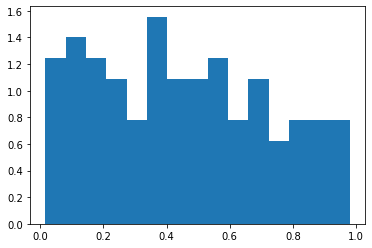

In [ ]:
histogram_i = plt.hist(teste.iloc[0,:], 15, density=True) #distribuicao: primeira linha

###Exercício 5: Utilizar a GAN treinada para gerar dados com a distribuição desejada

In [ ]:
output = generator.predict(teste)
output.shape

(1000, 500)

###Exercício 6: plotar o histograma da distribuição dos dados gerados pela GAN

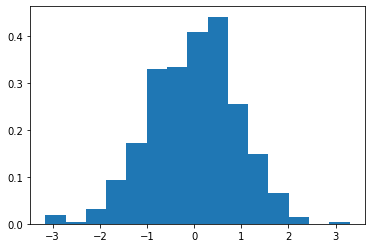

In [ ]:
hist = plt.hist(output[0,:], 15, density=True)